In [48]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numba import cuda, float32, jit, int32
from time import time
import math
from mpl_toolkits.mplot3d import Axes3D
from plotUtils import *
import copy

In [2]:
def analysis(ori_arr):
    even_res = []
    odd_res = []
    for i in range(len(ori_arr)):
        if i % 2 == 0:
            even_res.append((ori_arr[i+1] + ori_arr[i]) / 2)
        else:
            odd_res.append((ori_arr[i] - ori_arr[i-1]) / 2)
    return np.array(even_res), np.array(odd_res)

In [3]:
test_1 = np.ones(16)
test_1_even, test_1_odd = analysis(test_1)
print(test_1_even, test_1_odd)

[ 1.  1.  1.  1.  1.  1.  1.  1.] [ 0.  0.  0.  0.  0.  0.  0.  0.]


In [4]:
test_2 = np.linspace(0, 1, 16)
test_2_even, test_2_odd = analysis(test_2)
print(test_2, test_2_even, test_2_odd)

[ 0.          0.06666667  0.13333333  0.2         0.26666667  0.33333333
  0.4         0.46666667  0.53333333  0.6         0.66666667  0.73333333
  0.8         0.86666667  0.93333333  1.        ] [ 0.03333333  0.16666667  0.3         0.43333333  0.56666667  0.7
  0.83333333  0.96666667] [ 0.03333333  0.03333333  0.03333333  0.03333333  0.03333333  0.03333333
  0.03333333  0.03333333]


In [5]:
test_3 = np.linspace(0, 1, 16) ** 2
test_3_even, test_3_odd = analysis(test_3)
print(test_3, test_3_even, test_3_odd)

[ 0.          0.00444444  0.01777778  0.04        0.07111111  0.11111111
  0.16        0.21777778  0.28444444  0.36        0.44444444  0.53777778
  0.64        0.75111111  0.87111111  1.        ] [ 0.00222222  0.02888889  0.09111111  0.18888889  0.32222222  0.49111111
  0.69555556  0.93555556] [ 0.00222222  0.01111111  0.02        0.02888889  0.03777778  0.04666667
  0.05555556  0.06444444]


In [6]:
test_4 = np.random.rand(16)
test_4_even, test_4_odd = analysis(test_4)
print(test_4, test_4_even, test_4_odd)

[ 0.45867261  0.49393652  0.55976489  0.16321347  0.61350548  0.86882359
  0.59213387  0.21971924  0.59932582  0.94164524  0.28618017  0.70571177
  0.0880754   0.75660341  0.45417856  0.37626956] [ 0.47630456  0.36148918  0.74116453  0.40592656  0.77048553  0.49594597
  0.42233941  0.41522406] [ 0.01763196 -0.19827571  0.12765905 -0.18620732  0.17115971  0.2097658
  0.33426401 -0.0389545 ]


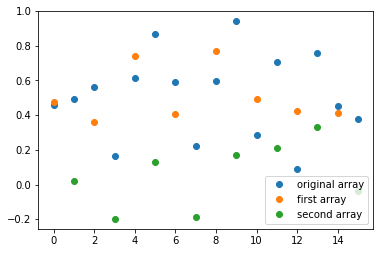

In [7]:
def plot_analysis(ori_arr, first_arr, second_arr):
    n_arr = len(ori_arr)
    fig = plt.figure()
    plt.plot(ori_arr, 'o', label='original array')
    plt.plot([i for i in range(0,n_arr-1,2)], first_arr, 'o', label='first array')
    plt.plot([i for i in range(1,n_arr,2)], second_arr, 'o', label='second array')
    plt.legend()
    plt.savefig(str([ k for k,v in locals().items() if v is ori_arr][0]) + ".jpg")
plot_analysis(test_4, test_4_even, test_4_odd)

In [8]:
def synthesis(first_arr, second_arr):
    syn_arr = np.stack((first_arr, second_arr))
    syn_arr = syn_arr.T
    syn_arr = syn_arr.flatten()
    n_arr = len(syn_arr)
    syn_res = np.empty(n_arr)
    for i in range(n_arr):
        if i % 2 == 0:
            syn_res[i] = syn_arr[i] - syn_arr[i+1]
        else:
            syn_res[i] = syn_arr[i-1] + syn_arr[i]    
    return syn_res

syn_1 = synthesis(test_2_even, test_2_odd)
print(syn_1 - test_2)

[  0.00000000e+00   0.00000000e+00   2.77555756e-17   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]


In [9]:
def gen_ic(n):
    init_arr = np.zeros(n)
    init_arr[-1] = 1
    return init_arr

In [10]:
def serial_laplace(u, epoch=1):
    n_arr = len(u)
#     v = u
    for e in range(epoch):
        for i in range(1, n_arr-1):
            u[i] = (u[i-1] + u[i+1]) / 2
#         u = v
    return u

In [11]:
def excute_2a(epoch=100):
    print("----- 2.a -----")
    init_arr = gen_ic(16)
    res = serial_laplace(init_arr, epoch)
    lin = np.linspace(0,1,16)
    diff = res - lin
    print("Epochs: ", epoch)
    print("Serial Laplace result: ")
    print("Difference with the correct result")
    print()

In [12]:
excute_2a()

----- 2.a -----
Epochs:  100
Serial Laplace result: 
Difference with the correct result



In [13]:
res = serial_laplace(init_arr, 100)
plt.plot(res, 'o', label='res')
lin = np.linspace(0,1,16)
plt.plot(lin, 'o')
plt.legend()
# print(res)
# print(lin)
# print(res - lin)

NameError: name 'init_arr' is not defined

In [14]:
TPB = 8

# Do iteration in kernel
@cuda.jit
def laplace_kernel(d_u, epoch):
    i = cuda.grid(1)
    n = d_u.shape[0]
    for e in range(epoch):
        if i >= n - 1 or i == 0:
            return
        d_u[i] = (d_u[i-1] + d_u[i+1]) / 2

def nu_laplace(u, epoch=10):
    n = u.shape[0]
    d_u = cuda.to_device(u)
    blocks = (n + TPB - 1) // TPB
    threads = TPB
    laplace_kernel[blocks, threads](d_u, epoch)
    return d_u.copy_to_host()


def excute_2b(epoch):
    print("----- 2.b -----")
    init_arr = gen_ic(16)
    res = nu_laplace(init_arr, epoch)
    lin = np.linspace(0,1,16)
    diff = res - lin
    print("Epochs: ", epoch)
    print("Serial Laplace result: ")
    print(res)
    print("Difference with the correct result")
    print(diff)
    print()



In [15]:
excute_2b(100)

----- 2.b -----
Epochs:  100
Serial Laplace result: 
[ 0.          0.05236637  0.10473274  0.15956471  0.21439669  0.27373821
  0.33307974  0.39820125  0.46332277  0.53449898  0.6056752   0.68213261
  0.75859003  0.83863654  0.91868305  1.        ]
Difference with the correct result
[ 0.         -0.0143003  -0.0286006  -0.04043529 -0.05226998 -0.05959512
 -0.06692026 -0.06846541 -0.07001057 -0.06550102 -0.06099147 -0.05120072
 -0.04140997 -0.02803013 -0.01465028  0.        ]



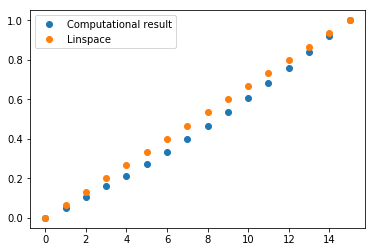

In [16]:
N = 16
init_arr = np.zeros(N)
init_arr[-1] = 1
res = nu_laplace(init_arr, 100)
# print(end_time - start_time)
plt.plot(res, 'o', label='Computational result')
lin = np.linspace(0,1,16)
plt.plot(lin, 'o', label='Linspace')
plt.legend()

In [20]:
# 2.c
TPB = 16
NSHARED = 18

@cuda.jit
def share_laplace_kernel_1(d_u, stencil, epoch):
    i = cuda.grid(1)
    n = d_u.shape[0]
    sh_u = cuda.shared.array(NSHARED, dtype=float32)
    
    if i >= n or i < 0:
        return
    
    radius = len(stencil) // 2
    tIdx = cuda.threadIdx.x
    shIdx = tIdx + radius
    sh_u[shIdx] = d_u[i]
    
    if tIdx < radius:
        sh_u[tIdx] = d_u[i - radius]
    elif tIdx > cuda.blockDim.x - 1 - radius:
        sh_u[tIdx + 2 * radius] = d_u[i + radius]
      
    cuda.syncthreads()
    
    if radius <= i <= n - 1 - radius:
        d_u[i] = 0
        for j in range(len(stencil)):       
            d_u[i] += (sh_u[shIdx + j - radius] * stencil[j])


@cuda.jit
def share_laplace_kernel_2(d_u, stencil, epoch):
    """Kernel function for problem 2.e, RAD=2."""
    i = cuda.grid(1)
    n = d_u.shape[0]
    sh_u = cuda.shared.array(NSHARED, dtype=float32)
    
    if i >= n or i < 0:
        return
    
    radius = len(stencil) // 2
    tIdx = cuda.threadIdx.x
    shIdx = tIdx + radius
    sh_u[shIdx] = d_u[i]
    
    # <=, >= because boudary conditions are fixed; 0, 1 because of the same reason
    if tIdx < radius:
#         sh_u[tIdx] = 0
        sh_u[tIdx] = d_u[i - radius]
    elif tIdx > cuda.blockDim.x - 1 - radius:
#         sh_u[tIdx + 2 * radius] = 1
        sh_u[tIdx + 2 * radius] = d_u[i + radius]

        
    cuda.syncthreads()
#     import pdb; pdb.set_trace()
#     if radius
    
    # if order is 1, comment out this part
#     if i == radius - 1 or i == n - radius:
# #         d_u[i] = 0
#         d_u[i] = (sh_u[shIdx - 1] +  sh_u[shIdx + 1]) / 2.0
    if i == 1:
        d_u[i] = 0
    if i == n - 2:
        d_u[i] = 1
    
    w = 0.5
    if radius <= i <= n - 1 - radius:
        temp = 0
        for j in range(len(stencil)):       
            temp += (sh_u[shIdx + j - radius] * stencil[j])
        d_u[i] = w * temp + (1 - w) * d_u[i]
            

def share_laplace(u, order=1, epoch=100, tol=1e-5):
    n = u.shape[0]
    
    if order == 1:
        stencil = np.array([1., 0., 1.], dtype=np.float32) / 2
        share_laplace_kernel = share_laplace_kernel_1
    elif order == 2:
        stencil = np.array([-1./12, 4./3, 0., 4./3, -1./12], dtype=np.float32) * 2 / 5
        share_laplace_kernel = share_laplace_kernel_2
        
    d_u = cuda.to_device(u)
    
    blocks = (n + TPB - 1) // TPB
    threads = TPB
    
    for e in range(epoch):
        pre_u = d_u.copy_to_host()
        share_laplace_kernel[blocks, threads](d_u, stencil, epoch)
        post_u = d_u.copy_to_host()
        diff = np.linalg.norm(post_u - pre_u)
        if diff < tol:
            break
    print(e+1)

    return d_u.copy_to_host()




100


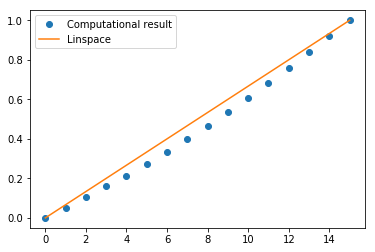

In [18]:
N = 16
init_arr = np.zeros(N)
init_arr[-1] = 1
res = share_laplace(init_arr, 1, 100)
# print(res)
plt.plot(res, 'o', label='Computational result')
lin = np.linspace(0,1,N)
plt.plot(lin, label='Linspace')
plt.legend()


In [21]:
def excute_2cde(problem):
    if problem == 'c':
        order = 1
        epoch = 100
        tol = 1e-20
        
    elif problem == 'd':
        order = 1
        epoch = 10000
        tol = 1e-5
    elif problem == 'e':
        order = 2
        epoch = 10000
        tol = 1e-5
    s = "----- 2." + problem + " -----"    
    print(s)
    init_arr = gen_ic(16)
    print("Epochs excuted: ")
    res = share_laplace(init_arr, order, epoch, tol)
    lin = np.linspace(0,1,16)
    diff = res - lin
    print("Current tolerance: ")
    print(tol)
    print("Serial Laplace result: ")
    print(res)
    print("Difference with the correct result")
    print(diff)
    print()
excute_2cde('c')
excute_2cde('d')
excute_2cde('e')

----- 2.c -----
Epochs excuted: 
100
Current tolerance: 
1e-20
Serial Laplace result: 
[ 0.          0.05236637  0.10473274  0.15956471  0.21439669  0.27373822
  0.33307976  0.39820127  0.46332279  0.534499    0.60567522  0.68213263
  0.75859004  0.83863655  0.91868305  1.        ]
Difference with the correct result
[ 0.         -0.0143003  -0.0286006  -0.04043529 -0.05226997 -0.05959511
 -0.06692024 -0.06846539 -0.07001054 -0.065501   -0.06099145 -0.0512007
 -0.04140996 -0.02803012 -0.01465028  0.        ]

----- 2.d -----
Epochs excuted: 
390
Current tolerance: 
1e-05
Serial Laplace result: 
[ 0.          0.06664307  0.13328613  0.19993328  0.26658043  0.33323504
  0.39988965  0.46655381  0.53321798  0.59989211  0.66656622  0.73324901
  0.79993179  0.86662048  0.9333092   1.        ]
Difference with the correct result
[  0.00000000e+00  -2.35999624e-05  -4.71999248e-05  -6.67169690e-05
  -8.62414638e-05  -9.82930263e-05  -1.10352039e-04  -1.12859408e-04
  -1.15351876e-04  -1.07890368

In [39]:
def excute_2e(epoch=1000, tol=1e-5):
    print("----- 2.e -----")
    init_arr = gen_ic(16)
    print("Epochs excuted: ")
    res = share_laplace(init_arr, order=2, epoch=1000, tol=1e-5)
    lin = np.linspace(0,1,16)
    diff = res - lin
    print("Current tolerance: ")
    print(tol)
    print("Serial Laplace result: ")
    print(res)
    print("Difference with the correct result")
    print(diff)
    print()
excute_2e(epoch=1000, tol=1e-5)

----- 2.e -----
Epochs excuted: 
630
Current tolerance: 
1e-05
Serial Laplace result: 
[ 0.          0.          0.07218722  0.14956163  0.22731688  0.30511149
  0.3829238   0.46075424  0.5386038   0.61647246  0.69435891  0.7722592
  0.85014526  0.92766714  1.          1.        ]
Difference with the correct result
[ 0.         -0.06666667 -0.06114611 -0.05043837 -0.03934979 -0.02822184
 -0.0170762  -0.00591243  0.00527047  0.01647246  0.02769225  0.03892587
  0.05014526  0.06100047  0.06666667  0.        ]



In [22]:
# 3
def gen_u():
    x_scale = np.linspace(-2,2,64)
    y_scale = np.linspace(-2,2,64)
    u = np.empty(64*64).reshape(64,64)
    for i in range(64):
        for j in range(64):
            u[i,j] = min_dis(x_scale[i], y_scale[j])
    return u

            
def min_dis(x, y):
    dis1 = (x - 1) ** 2 + y ** 2
    dis2 = (x + 1) ** 2 + y ** 2
    dis3 = x ** 2 + (y - 1) ** 2
    min_sq = min(dis1, min(dis2, dis3))
    return math.sqrt(min_sq)

def plot_contour()

In [54]:
def excute_3a():
    x_scale = np.linspace(-2,2,64)
    y_scale = np.linspace(-2,2,64)
    u = gen_u()
    plot3d(u.T, x_scale, y_scale, titlestring='3.a_3Dplot',vars=['x','y','f'])
    fig = plt.figure()
    plt.contourf(u.T)
    plt.title("3.a_contoutplot")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('square')
    plt.show()

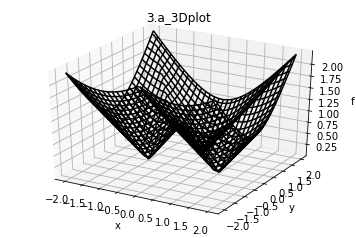

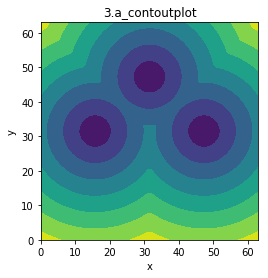

In [55]:
excute_3a()

In [24]:
plot3d(u.T, x_scale, y_scale, titlestring='',vars=['x','y','f'])

NameError: name 'u' is not defined

/home/nqiao/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


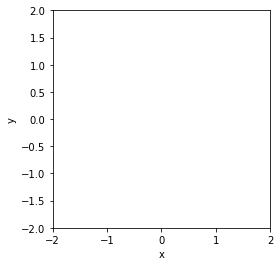

In [49]:
u = gen_u()
x_scale = np.linspace(-2,2,64)
y_scale = np.linspace(-2,2,64)
arraycontourplot(u.T, x_scale, y_scale, vars=['x','y'], titlestring='', filled=False)

In [283]:
# 3.b 
TPBX = 16
@cuda.jit
def del_kernel(d_u, d_out):
    i, j = cuda.grid(2)
    nx, ny = d_u.shape
    if i < nx - 1 and j < ny - 1 and i > 0 and j > 0:
        d_out[i-1, j-1] = 0.25 * (d_u[i+1, j] - d_u[i-1, j]) ** 2 + 0.25 * (d_u[i, j+1] - d_u[i, j-1]) ** 2

def nu_del():
    u = gen_u()
    
    n = u.shape[0]
    d_u = cuda.to_device(u)
    d_out = cuda.device_array((n - 2, n - 2), dtype = np.float32)
    gridDims = ((n + TPB - 1) // TPB, (n + TPB - 1) // TPB)
    blockDims = (TPB, TPB)
    del_kernel[gridDims, blockDims](d_u, d_out)
    return d_out.copy_to_host()
        

[[ 2.23606798  2.17946392  2.12324951 ...,  2.12324951  2.17946392
   2.23606798]
 [ 2.20840375  2.15107185  2.09409541 ...,  2.09409541  2.15107185
   2.17946392]
 [ 2.18223663  2.1241986   2.06648135 ...,  2.06648135  2.09409541
   2.12324951]
 ..., 
 [ 2.18223663  2.1241986   2.06648135 ...,  2.06648135  2.09409541
   2.12324951]
 [ 2.20840375  2.15107185  2.09409541 ...,  2.09409541  2.15107185
   2.17946392]
 [ 2.23606798  2.17946392  2.12324951 ...,  2.12324951  2.17946392
   2.23606798]]


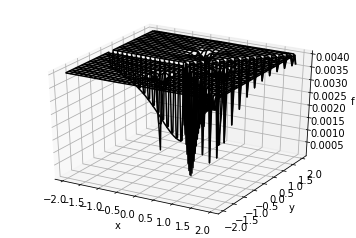

[[ 0.00403016  0.00403006  0.00402994 ...,  0.00402994  0.00403006
   0.00364389]
 [ 0.00403023  0.00403013  0.00403001 ...,  0.00403001  0.00361105
   0.00403006]
 [ 0.00403031  0.00403021  0.00403009 ...,  0.00357403  0.00403001
   0.00402994]
 ..., 
 [ 0.00403031  0.00403021  0.00403009 ...,  0.00357403  0.00403001
   0.00402994]
 [ 0.00403023  0.00403013  0.00403001 ...,  0.00403001  0.00361105
   0.00403006]
 [ 0.00403016  0.00403006  0.00402994 ...,  0.00402994  0.00403006
   0.00364389]]


In [284]:
u = gen_u()
print(u)
del_u = nu_del()
plot3d(del_u, x_scale[1:63], y_scale[1:63], titlestring='',vars=['x','y','f'])
# plot3d(del_u, x_scale, y_scale, titlestring='',vars=['x','y','f'])

print(del_u)

In [306]:
# 3.c



@cuda.jit
def share_del_kernel(d_u, d_out):
    RAD = 1
    SH_N = 10
    i, j = cuda.grid(2)
    dims = d_u.shape
    if i >= dims[0] or j >= dims[1]:
        return 
    
    t_i = cuda.threadIdx.x
    t_j = cuda.threadIdx.y

    NX = cuda.blockDim.x
    NY = cuda.blockDim.y

    sh_i = t_i + RAD
    sh_j = t_j + RAD

    sh_u = cuda.shared.array(shape = (SH_N,SH_N), dtype = float32)

    #Load regular values
    sh_u[sh_i, sh_j] = d_u[i, j]
    
    #Halo edge values
    if t_i<RAD:
        sh_u[sh_i - RAD, sh_j] = d_u[i-RAD, j]
        sh_u[sh_i + NX , sh_j] = d_u[i+NX , j]

    if t_j<RAD:
        sh_u[sh_i, sh_j - RAD] = d_u[i, j - RAD]
        sh_u[sh_i, sh_j + NY ] = d_u[i, j + NY ]
        
    cuda.syncthreads()
    
    if i > 0 and j > 0 and i < dims[0] - 1 and j < dims[1] - 1:
        d_out[i-1, j-1] = 0.25 * (sh_u[sh_i+1, sh_j] - sh_u[sh_i-1, sh_j]) ** 2 + 0.25 * (sh_u[sh_i, sh_j+1] - sh_u[sh_i, sh_j-1]) ** 2
        

        

def share_del():
    TPB = 8
    u = gen_u()
    d_u = cuda.to_device(u)
    dims = u.shape
    d_out = cuda.device_array((dims[0] - 2, dims[1] - 2), dtype = np.float32)
    
    gridSize = [(dims[0]+TPB-1)//TPB, (dims[1]+TPB-1)//TPB]
    blockSize = [TPB, TPB]
    share_del_kernel[gridSize, blockSize](d_u, d_out)
    return d_out.copy_to_host()

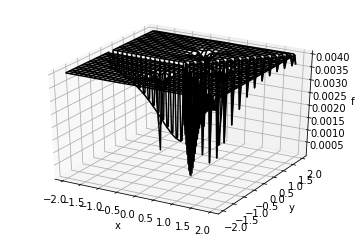

In [307]:
share_del_u = share_del()
share_del_u
plot3d(share_del_u, x_scale[1:63], y_scale[1:63], titlestring='',vars=['x','y','f'])

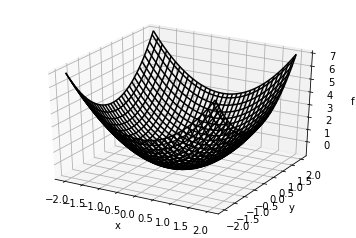

In [59]:
# 4.a
def gen_f():
    x_scale = np.linspace(-2,2,64)
    y_scale = np.linspace(-2,2,64)
    f = np.empty(64*64).reshape(64,64)
    for i in range(64):
        for j in range(64):
            f[i,j] = x_scale[i] ** 2 + y_scale[j] ** 2 - 1
    return f
plot3d(gen_f(), x_scale, y_scale, titlestring='',vars=['x','y','f'])

In [60]:
@cuda.jit
def upwind_kernel(d_u):
    i, j = cuda.grid(2)
    nx, ny = d_u.shape
    if i < nx - 1 and j < ny - 1 and i > 0 and j > 0:
        if d_u[i, j] > 0:
            t1 = min(d_u[i-1, j], d_u[i+1, j])
            t2 = min(d_u[i, j-1], d_u[i, j+1])
            h = 4 / (nx - 1)
            a = 2
            b = -2 * (t1 + t2)
            c = t1 ** 2 + t2 ** 2 - h ** 2
            delta = b ** 2 - 4 * a * c
            if delta >= 0:
                t = (-b + math.sqrt(delta)) / (2*a)
                if t > max(t1, t2):
                    d_u[i, j] = t
                elif t2 > t > t1:
                    d_u[i, j] = t1 + h
                elif t1 > t > t2:
                    d_u[i, j] = t2 + h

def nu_upwind(f, epoch=1):
    TPB=8
    n = f.shape[0]
    d_f = cuda.to_device(f)
#     d_out = cuda.device_array((n - 2, n - 2), dtype = np.float32)
    gridDims = ((n + TPB - 1) // TPB, (n + TPB - 1) // TPB)
    blockDims = (TPB, TPB)
    for e in range(epoch):
        upwind_kernel[gridDims, blockDims](d_f)
    return d_f.copy_to_host()

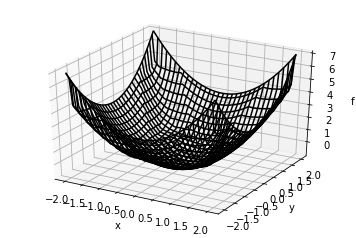

In [61]:
# upwind_res = nu_upwind(1)
f_0 = gen_f()
f_10 = nu_upwind(f_0, 10)
plot3d(f_10, x_scale, y_scale, titlestring='',vars=['x','y','f'])

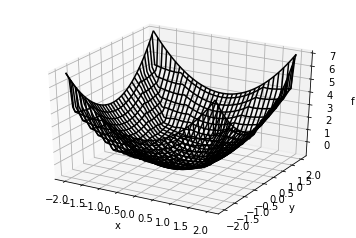

In [62]:
f_20 = nu_upwind(f_0, 20)
plot3d(f_20, x_scale, y_scale, titlestring='',vars=['x','y','f'])

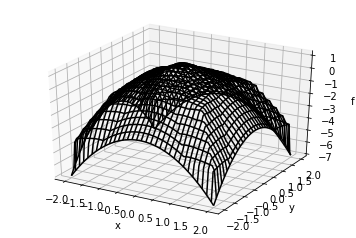

In [63]:
f_28 = nu_upwind(-f_20, 8)
plot3d(f_28, x_scale, y_scale, titlestring='',vars=['x','y','f'])

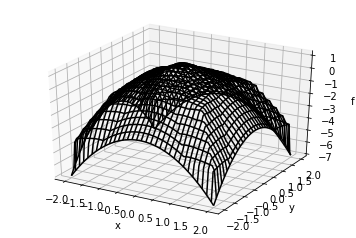

In [64]:
f_36 = nu_upwind(-f_20, 16)
plot3d(f_28, x_scale, y_scale, titlestring='',vars=['x','y','f'])

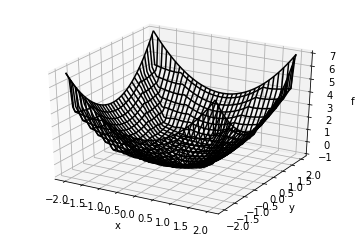

In [65]:
f_136 = nu_upwind(-f_36, 100)
plot3d(f_136, x_scale, y_scale, titlestring='',vars=['x','y','f'])

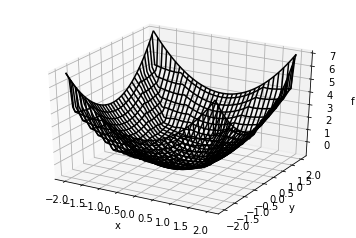

In [66]:
f_136_dir = nu_upwind(f_0, 136)
plot3d(f_136_dir, x_scale, y_scale, titlestring='',vars=['x','y','f'])